In [13]:
#numeric: pandas and numpy
import numpy as np
import pandas as pd
import seaborn as sns

# graphics
%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 

from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score,zero_one_loss

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from mlxtend.evaluate import mcnemar

## Read Data

In [98]:
name_features = []
with open('sensors-19-05524-s001/sensors-19-05524-s001_new/labels.txt', 'r') as file:
    content = file.read()
    cols = content.split('\n')
   # print(cols)
    name_features = cols[1:-2]   # remove first column and the last two
    
Y = []
X = []

with open('sensors-19-05524-s001/sensors-19-05524-s001_new/data.txt', 'r') as file:
    content = file.read()
    cols = content.split('\n')
    for c in cols[:-1]:
        data = c.split(',')
        X.append(data[1:-1])
        Y.append(data[-1])
        
# Convert String to Float
X = np.array(X).astype(float)
print(type(X[0][0]))

#Convert String to Int
Y = np.array(Y).astype(int)
print(type(Y[0]))
    
print(f"Features: {len(X[0])}")
print(f"Records in DB: {len(X)}")
print(f"Size Y: {len(Y)}")

<class 'numpy.float64'>
<class 'numpy.int64'>
Features: 533
Records in DB: 4480
Size Y: 4480


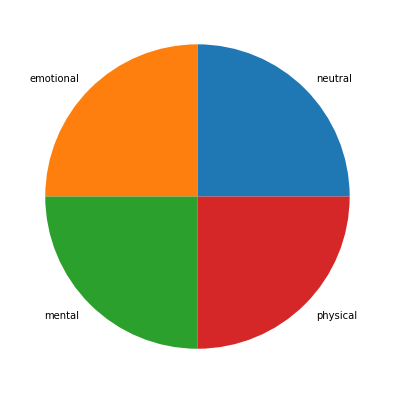

In [103]:
labels = list(range(1,5))
quantity = [np.sum(Y == label) for label in labels]

# Creating plot 
fig = plt.figure(figsize =(10, 7)) 
plt.pie(quantity, labels=["neutral", "emotional", "mental", "physical"]) 
  
# show plot 
plt.show()

## Selection of Features (PCA)

In [15]:
data_features = pd.DataFrame(X, dtype='float')

corr_matrix = data_features.corr().abs()

In [16]:
def drop_features(ds, corr, threshold=0.8):
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return ds.drop(ds[to_drop], axis=1)

reduced_dataset = drop_features(data_features, corr_matrix)
reduced_dataset.head()

,0,1,4,5,8,11,13,14,15,18,...,445,447,448,451,454,456,485,488,489,495
0,-0.004125,0.254095,-0.538509,5.95534,-0.10937,-0.065212,0.001901,231.814,16.2733,0.374904,...,-4.85458,2.357070,9.48421,-15.5916,4.14944,-2.59232,16.0,798.68,0.63875,31.4247
1,0.031029,0.193761,0.781415,5.18794,-0.08737,-0.057924,0.002046,230.500,15.5536,0.397898,...,-6.90565,2.476570,11.24150,-16.9271,5.89258,-2.59483,20.0,798.68,0.68500,31.4359
2,0.015678,0.182336,0.881194,5.66530,-0.08037,-0.042190,0.002114,240.707,20.8210,0.725535,...,-5.94592,1.068740,4.24641,-14.9459,24.62180,-2.60259,24.0,798.68,0.68500,31.4478
3,0.014525,0.176636,1.024900,6.10968,-0.08037,-0.044888,0.002177,247.308,22.2275,0.267597,...,-6.18900,0.828304,4.28808,-14.6317,-28.60590,-2.61594,28.0,798.68,0.68375,31.4331
4,0.010349,0.179248,0.935697,5.83902,-0.08337,-0.041310,0.002217,247.744,20.1621,0.715390,...,-6.49062,0.988309,5.30232,-13.6923,-65.12220,-2.63103,32.0,798.68,0.71375,31.4347


In [17]:
X = reduced_dataset.to_numpy(dtype="float")
print(f"Features: {len(X[0])}")
print(f"Records in DB: {len(X)}")
print(f"Size Y: {len(Y)}")

Features: 103
Records in DB: 4480
Size Y: 4480


In [18]:
def get_best_x_features(df, dclass, num_features=50):

    df = (df - np.min(df))/(np.max(df) - np.min(df))
    
    k_bestfeatures = SelectKBest(score_func = f_classif)
    rankings = k_bestfeatures.fit(df, dclass)
    b=list(rankings.scores_)
    a=list(range(0,len(b)))

    sf = [g for _,g in sorted(zip(b,a))]
    sf=sf[len(a)-num_features:len(a)]
    sf=reversed(sf)
    inx=[]
    for chosen in sf:
        inx.append(chosen)
    
    dataset = pd.DataFrame(df, dtype='float')
    
    return dataset[inx].to_numpy(dtype='float')

In [19]:
X = get_best_x_features(X,Y)
print(f"Features: {len(X[0])}")
print(f"Records in DB: {len(X)}")
print(f"Size Y: {len(Y)}")

Features: 50
Records in DB: 4480
Size Y: 4480


## Training Data

In [20]:
k_fold = StratifiedKFold(n_splits=4)

In [84]:
def processKFold(model, X, Y):
    
    scores = []
    loss = []
    
    for train_indexes, test_indexes in k_fold.split(X,Y):

        # normalize the data
        scaler = StandardScaler()

        X_train, X_test = X[train_indexes], X[test_indexes]
        Y_train, Y_test = Y[train_indexes], Y[test_indexes]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, Y_train)

        Y_pred = model.predict(X_test)
        
        scores.append(accuracy_score(Y_test, Y_pred))
        loss.append(zero_one_loss(Y_test, Y_pred))
        
    return np.mean(scores), np.mean(loss), Y_pred == Y_test

In [22]:
# Multilayer feedforward neural network

# change number after
def mlp8(X, Y):
    
    ppnML = MLPClassifier(hidden_layer_sizes=(8), activation="relu", solver='sgd', 
                          learning_rate='adaptive', max_iter=1100, random_state=1, learning_rate_init=0.01)

    return processKFold(ppnML, X, Y)

In [23]:
# svm rbf and svm linear 

def svmRBF(X, Y):

    svmRBF = svm.SVC(kernel='rbf')
    
    return processKFold(svmRBF, X, Y)

In [24]:
def svmLinear(X, Y):

    svmLinear = svm.SVC(kernel='linear')
    
    return processKFold(svmLinear, X, Y)

In [25]:
def knn(X, Y, k=5):
    
    knn_c = KNeighborsClassifier(n_neighbors=k)
     
    return processKFold(knn_c, X, Y)

# Tunning

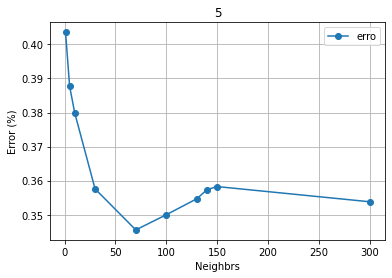

min: 0.3455357142857143
min2: 70


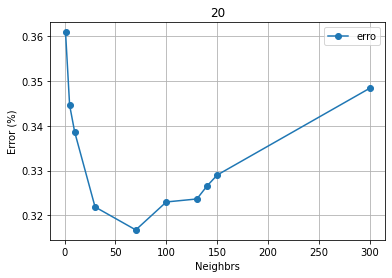

min: 0.31674107142857144
min2: 70


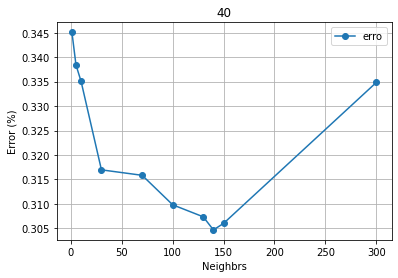

min: 0.3046875
min2: 140


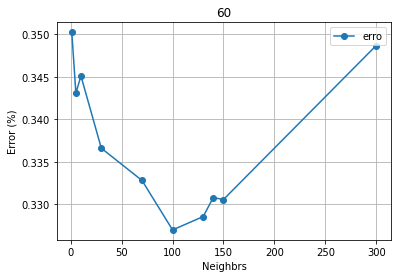

min: 0.3270089285714286
min2: 100


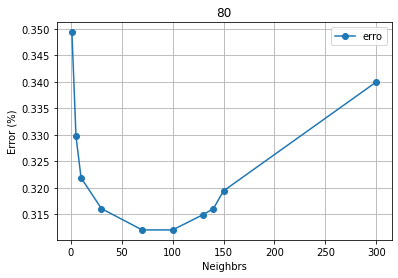

min: 0.3120535714285714
min2: 70


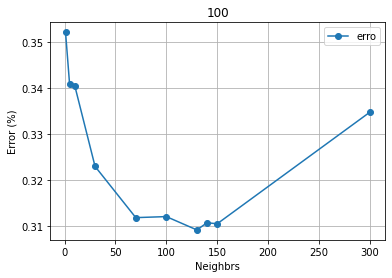

min: 0.3091517857142857
min2: 130


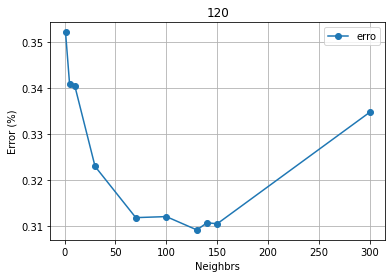

min: 0.3091517857142857
min2: 130


In [26]:
# Teste Best k of neighbors
neighbors = [1, 5, 10, 30, 70, 100, 130, 140, 150, 300]
#neighbors = [130, 140, 141]

num_features = [5, 20, 40 ,60, 80, 100, 120]

acc_knn = []
err_knn = []
for f in num_features:
    acc_knn = []
    err_knn = []
    for i in neighbors:

        X_new = get_best_x_features(X,Y, f)

        r = knn(X_new, Y, i)
        #print(r)
        acc_knn.append(r[0])
        err_knn.append(r[1])
    
    
    #plt.plot(neighbors, acc_knn, marker="o" ,label="MPL8")
    plt.plot(neighbors, err_knn, marker="o" ,label="erro")
    plt.legend()
    plt.xlabel("Neighbrs")
    plt.ylabel("Error (%)")
    plt.title(str(f))
    plt.grid()
    plt.show()
    print("min:", np.min(err_knn))
    print("min2:", neighbors[np.argmin(err_knn)])

### Variate number of features
In this section, we gonna variate the number of best features to trainning the model, to try to find the best number of features to get good results. 

In [27]:
num_features = [5, 20, 40 ,60, 80, 100, 120]

loss_mpl8 = []
loss_svm_linear = []
loss_svm_rbf = []
loss_knn = []

for num_feature in num_features:
    
    print(f"Number of features: {num_feature}")
    
    X_new = get_best_x_features(X,Y, num_feature)
    
    loss_mpl8.append(mlp8(X_new, Y)[1])
    loss_svm_rbf.append(svmRBF(X_new, Y)[1])
    loss_svm_linear.append(svmLinear(X_new, Y)[1])
    loss_knn.append(knn(X_new, Y, 140)[1])

# convert to numpy array to be easily to convert values to percentage 
loss_mpl8 = np.array(loss_mpl8)
loss_svm_rbf = np.array(loss_svm_rbf)
loss_svm_linear = np.array(loss_svm_linear)
loss_knn = np.array(loss_knn)

Number of features: 5
Number of features: 20
Number of features: 40
Number of features: 60
Number of features: 80
Number of features: 100
Number of features: 120


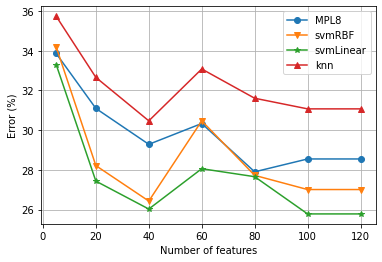

In [28]:
plt.plot(num_features, loss_mpl8 * 100, marker="o" ,label="MPL8")
plt.plot(num_features, loss_svm_rbf * 100, marker="v", label="svmRBF")
plt.plot(num_features, loss_svm_linear * 100, marker="*" , label="svmLinear")
plt.plot(num_features, loss_knn * 100, marker="^" , label="knn")
plt.legend()
plt.xlabel("Number of features")
plt.ylabel("Error (%)")
plt.grid()

In [30]:
# only for test
acc_mpl, loss_mpl, _ = mlp8(X, Y)

print(f"MPL:\nAcc: {acc_mpl}\nLoss: {loss_mpl}")

MPL:
Acc: 0.7194196428571429
Loss: 0.2805803571428571


In [31]:
acc_svmRBF, loss_svmRBF,_ = svmRBF(X, Y)

print(f"svmRBF:\nAcc: {acc_svmRBF}\nLoss: {loss_svmRBF}")

svmRBF:
Acc: 0.7299107142857143
Loss: 0.2700892857142857


In [32]:
acc_svmLinear, loss_svmLinear,_ = svmLinear(X, Y)

print(f"svmLinear:\nAcc: {acc_svmLinear}\nLoss: {loss_svmLinear}")

svmLinear:
Acc: 0.7417410714285715
Loss: 0.25825892857142857


# Comparison between Models

In [85]:
def contingency_table(model1_correct, model2_correct):
    res = np.zeros((2,2))
    res[0,0] = np.sum(np.logical_and(model1_correct, model2_correct))
    res[0,1] = np.sum(np.logical_and(model1_correct, np.logical_not(model2_correct)))
    res[1,0] = np.sum(np.logical_and(np.logical_not(model1_correct), model2_correct))
    res[1,1] = np.sum(np.logical_and(np.logical_not(model1_correct), np.logical_not(model2_correct)))
    
    return res

In [81]:
def confusion_matrix(correct_values, model1_values):
    return confusion_matrix(correct_values, model1_values, normalize='true')

In [95]:
def get_comparable_matrix(list_of_model_values, p_threshold=0.05):
    num_models = len(list_of_model_values)
    chi2_matrix = np.zeros((num_models, num_models))
    p_value_matrix = np.zeros((num_models, num_models))
    for i in range(num_models):
        for j in range(i+1, num_models):
            cont_table = contingency_table(list_of_model_values[i], list_of_model_values[j])
            chi2, p_value = mcnemar(ary=cont_table, corrected=True)
            chi2_matrix[i, j] = chi2
            chi2_matrix[j, i] = chi2
            p_value_matrix[i, j] = p_value
            p_value_matrix[j, i] = p_value
    print(p_value_matrix)
    print(chi2_matrix)
    print(p_value_matrix >= p_threshold)
    return chi2_matrix, p_value_matrix, p_value_matrix >= p_threshold

In [87]:
# For test, lets compare the rbf, linear and mlp models
list_of_values = [
    mlp8(X, Y)[2],
    svmRBF(X, Y)[2],
    svmLinear(X, Y)[2],
]

In [96]:
get_comparable_matrix(list_of_values)

[[670. 108.]
 [134. 208.]]
[[720.  58.]
 [158. 184.]]
[[769.  35.]
 [109. 207.]]
[[0.00000000e+00 1.08041017e-01 1.62697926e-11]
 [1.08041017e-01 0.00000000e+00 1.17709270e-09]
 [1.62697926e-11 1.17709270e-09 0.00000000e+00]]
[[ 0.          2.58264463 45.375     ]
 [ 2.58264463  0.         37.00694444]
 [45.375      37.00694444  0.        ]]
[[False  True False]
 [ True False False]
 [False False False]]


(array([[ 0.        ,  2.58264463, 45.375     ],
        [ 2.58264463,  0.        , 37.00694444],
        [45.375     , 37.00694444,  0.        ]]),
 array([[0.00000000e+00, 1.08041017e-01, 1.62697926e-11],
        [1.08041017e-01, 0.00000000e+00, 1.17709270e-09],
        [1.62697926e-11, 1.17709270e-09, 0.00000000e+00]]),
 array([[False,  True, False],
        [ True, False, False],
        [False, False, False]]))